In [24]:
import numpy as np

arr = np.load("zero_shot").round()


np.save("logit_25", arr[:, 0])
np.save("logit_50", arr[:, 1])
np.save("logit_75", arr[:, 2])

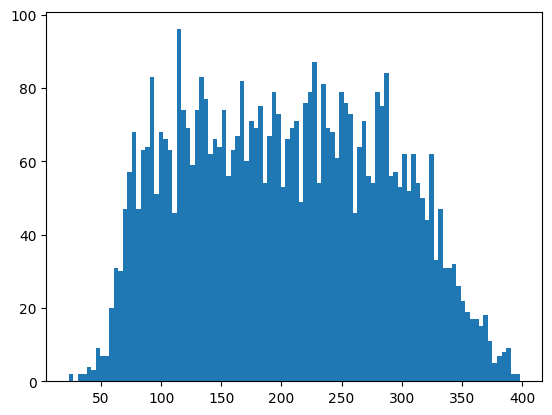

In [38]:
import matplotlib.pyplot as plt
arr = np.load("bert_reg.npy")
plt.hist(arr, bins = 100)
plt.show()

In [26]:
arr = np.load("bert_reg.npy")
arr

array([150., 300.,  98., ..., 133., 316., 155.])